In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import load_iris
from sklearn.cluster import KMeans, DBSCAN
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score, silhouette_samples
from sklearn.neighbors import NearestNeighbors
import warnings
warnings.filterwarnings('ignore')

# Setup plotting style
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("husl")

print("Semua library berhasil diimport!")

Semua library berhasil diimport!


In [6]:
#LOAD DAN EKSPLORASI DATASET IRIS
def load_and_explore_iris():
    # Load dataset
    iris = load_iris()
    X = iris.data
    y = iris.target
    feature_names = iris.feature_names
    target_names = iris.target_names
    
    # Create DataFrame
    df = pd.DataFrame(X, columns=feature_names)
    df['species'] = [target_names[i] for i in y]
    
    print("=== INFORMASI DATASET IRIS ===")
    print(f"Shape data: {X.shape}")
    print(f"Feature names: {feature_names}")
    print(f"Target names: {target_names}")
    print(f"Number of classes: {len(np.unique(y))}")
    
    # Statistical summary
    print("\n=== STATISTICAL SUMMARY ===")
    print(df.describe())
    
    # Class distribution
    print("\n=== DISTRIBUSI KELAS ===")
    print(df['species'].value_counts())
    
    return X, y, df, feature_names, target_names

X, y, df, feature_names, target_names = load_and_explore_iris()



=== INFORMASI DATASET IRIS ===
Shape data: (150, 4)
Feature names: ['sepal length (cm)', 'sepal width (cm)', 'petal length (cm)', 'petal width (cm)']
Target names: ['setosa' 'versicolor' 'virginica']
Number of classes: 3

=== STATISTICAL SUMMARY ===
       sepal length (cm)  sepal width (cm)  petal length (cm)  \
count         150.000000        150.000000         150.000000   
mean            5.843333          3.057333           3.758000   
std             0.828066          0.435866           1.765298   
min             4.300000          2.000000           1.000000   
25%             5.100000          2.800000           1.600000   
50%             5.800000          3.000000           4.350000   
75%             6.400000          3.300000           5.100000   
max             7.900000          4.400000           6.900000   

       petal width (cm)  
count        150.000000  
mean           1.199333  
std            0.762238  
min            0.100000  
25%            0.300000  
50%     

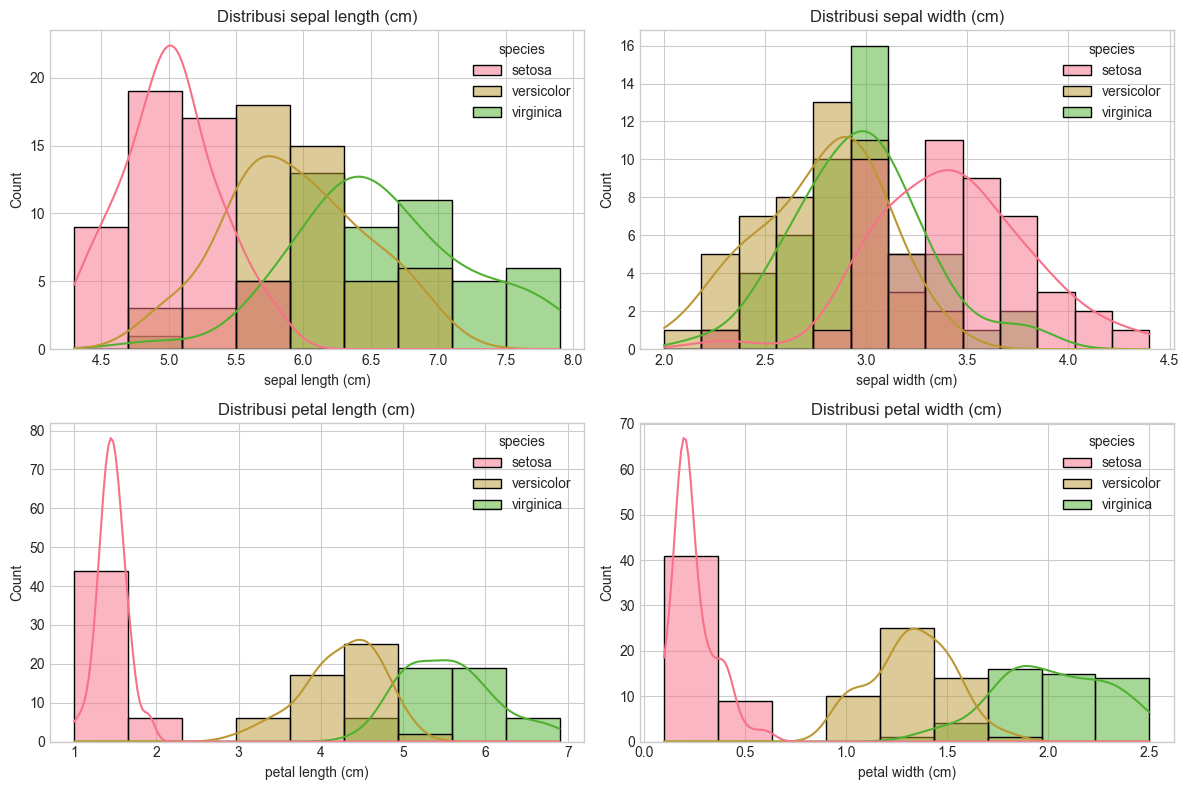

In [7]:
# Visualisasi distribusi features
fig, axes = plt.subplots(2, 2, figsize=(12, 8))
features = df.columns[:-1]

for i, feature in enumerate(features):
    row, col = i // 2, i % 2
    sns.histplot(data=df, x=feature, hue='species', ax=axes[row, col], kde=True)
    axes[row, col].set_title(f'Distribusi {feature}')

plt.tight_layout()
plt.show()

In [8]:
# PREPROCESSING DATA
def preprocess_data(X):
    """
    Standardisasi data untuk clustering
    """
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    
    print("=== HASIL STANDARDISASI ===")
    print(f"Original data - Mean: {np.mean(X, axis=0).round(2)}")
    print(f"Original data - Std: {np.std(X, axis=0).round(2)}")
    print(f"Scaled data - Mean: {np.mean(X_scaled, axis=0).round(2)}")
    print(f"Scaled data - Std: {np.std(X_scaled, axis=0).round(2)}")
    
    return X_scaled, scaler

X_scaled, scaler = preprocess_data(X)

=== HASIL STANDARDISASI ===
Original data - Mean: [5.84 3.06 3.76 1.2 ]
Original data - Std: [0.83 0.43 1.76 0.76]
Scaled data - Mean: [-0. -0. -0. -0.]
Scaled data - Std: [1. 1. 1. 1.]


In [ ]:
# IMPLEMENTASI K-MEANS CLUSTERING
def simple_kmeans_analysis(X, k_values=[2, 3, 4, 5]):
    """
    Analisis K-Means sederhana untuk berbagai nilai k
    """
    results = {}
    
    print("=== ANALISIS K-MEANS UNTUK BERBAGAI NILAI K ===")
    
    for k in k_values:
        # Training K-Means
        kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
        kmeans_labels = kmeans.fit_predict(X)
        kmeans_centers = kmeans.cluster_centers_
        
        # Hitung metrics sederhana
        wcss = kmeans.inertia_
        cluster_sizes = np.bincount(kmeans_labels)
        
        # Simpan results
        results[k] = {
            'labels': kmeans_labels,
            'centers': kmeans_centers,
            'wcss': wcss,
            'cluster_sizes': cluster_sizes,
            'model': kmeans
        }
        
        print(f"\nK = {k}:")
        print(f"  - WCSS: {wcss:.2f}")
        print(f"  - Cluster sizes: {cluster_sizes}")
        print(f"  - Centers shape: {kmeans_centers.shape}")
    
    return results

# Jalankan analisis untuk k=2,3,4,5
kmeans_results = simple_kmeans_analysis(X_scaled)

# Pilih k=3 untuk analisis lebih lanjut (karena dataset iris punya 3 species)
k_selected = 3
kmeans_model = kmeans_results[k_selected]['model']
kmeans_labels = kmeans_results[k_selected]['labels']
kmeans_centers = kmeans_results[k_selected]['centers']

print(f"\n K-Means dengan k={k_selected} dipilih untuk analisis lanjutan")

=== ANALISIS K-MEANS UNTUK BERBAGAI NILAI K ===

K = 2:
  - WCSS: 222.36
  - Cluster sizes: [100  50]
  - Centers shape: (2, 4)

K = 3:
  - WCSS: 139.82
  - Cluster sizes: [53 50 47]
  - Centers shape: (3, 4)

K = 4:
  - WCSS: 114.09
  - Cluster sizes: [47 53 28 22]
  - Centers shape: (4, 4)

K = 5:
  - WCSS: 90.93
  - Cluster sizes: [28 48 25 27 22]
  - Centers shape: (5, 4)

🎯 K-Means dengan k=3 dipilih untuk analisis lanjutan


In [ ]:
# IMPLEMENTASI DBSCAN CLUSTERING
def simple_dbscan_analysis(X, eps_values=[0.3, 0.5, 0.7, 1.0], min_samples=5):
    """
    Analisis DBSCAN sederhana untuk berbagai nilai eps
    """
    results = {}
    
    print("=== ANALISIS DBSCAN UNTUK BERBAGAI NILAI EPS ===")
    
    for eps in eps_values:
        # Training DBSCAN
        dbscan = DBSCAN(eps=eps, min_samples=min_samples)
        dbscan_labels = dbscan.fit_predict(X)
        
        # Hitung metrics sederhana
        n_clusters = len(set(dbscan_labels)) - (1 if -1 in dbscan_labels else 0)
        n_noise = list(dbscan_labels).count(-1)
        cluster_sizes = np.bincount(dbscan_labels + 1) if n_clusters > 0 else [n_noise]
        
        # Simpan results
        results[eps] = {
            'labels': dbscan_labels,
            'n_clusters': n_clusters,
            'n_noise': n_noise,
            'cluster_sizes': cluster_sizes,
            'model': dbscan
        }
        
        print(f"\nEPS = {eps}:")
        print(f"  - Number of clusters: {n_clusters}")
        print(f"  - Noise points: {n_noise}")
        print(f"  - Cluster distribution: {cluster_sizes}")
    
    return results

# Jalankan analisis DBSCAN
dbscan_results = simple_dbscan_analysis(X_scaled)

# Pilih parameter yang memberikan hasil reasonable
eps_selected = 0.5
dbscan_model = dbscan_results[eps_selected]['model']
dbscan_labels = dbscan_results[eps_selected]['labels']

print(f"\n🎯 DBSCAN dengan eps={eps_selected} dipilih untuk analisis lanjutan")

=== ANALISIS DBSCAN UNTUK BERBAGAI NILAI EPS ===

EPS = 0.3:
  - Number of clusters: 3
  - Noise points: 120
  - Cluster distribution: [120  13  12   5]

EPS = 0.5:
  - Number of clusters: 2
  - Noise points: 34
  - Cluster distribution: [34 45 71]

EPS = 0.7:
  - Number of clusters: 2
  - Noise points: 6
  - Cluster distribution: [ 6 48 96]

EPS = 1.0:
  - Number of clusters: 2
  - Noise points: 3
  - Cluster distribution: [ 3 49 98]

🎯 DBSCAN dengan eps=0.5 dipilih untuk analisis lanjutan


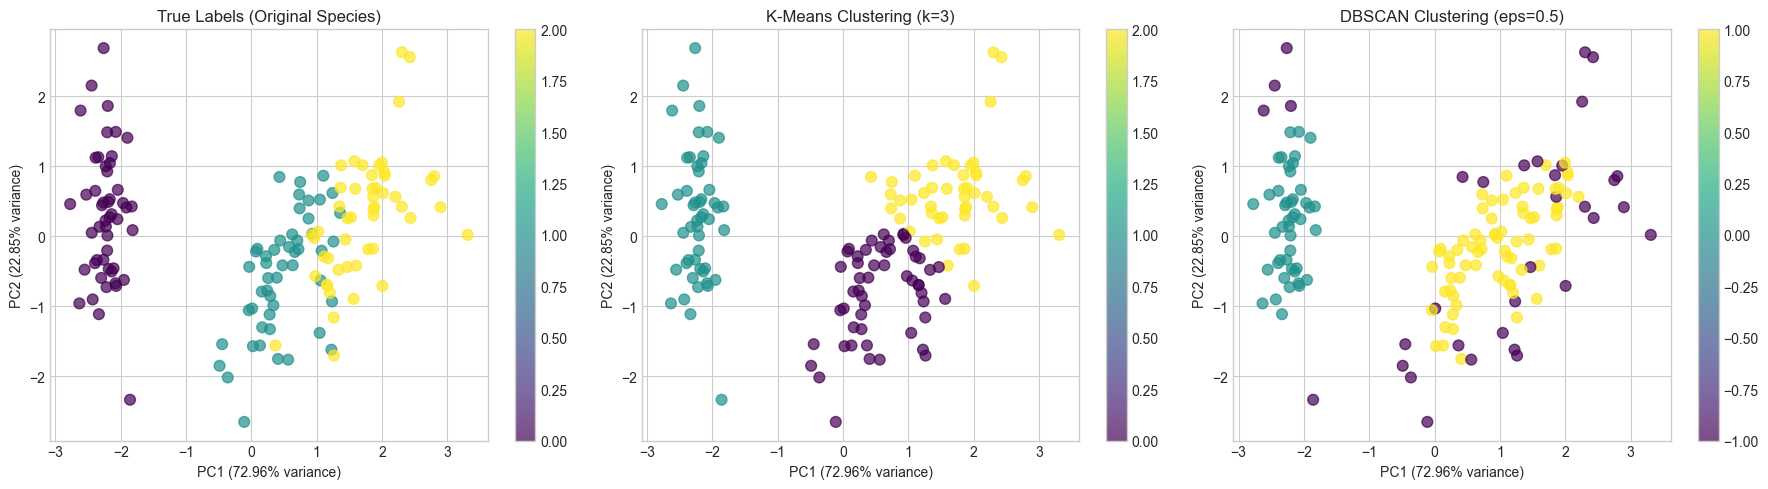

=== PCA ANALYSIS ===
Explained variance ratio: [0.72962445 0.22850762]
Total explained variance: 95.81%


In [ ]:
# VISUALISASI HASIL CLUSTERING
def visualize_clustering_results(X, true_labels, kmeans_labels, dbscan_labels, feature_names):
    """
    Visualisasi hasil clustering menggunakan PCA
    """
    # Apply PCA untuk reduksi dimensi
    pca = PCA(n_components=2)
    X_pca = pca.fit_transform(X)
    
    # Create subplots
    fig, axes = plt.subplots(1, 3, figsize=(18, 5))
    
    # Plot 1: True Labels
    scatter1 = axes[0].scatter(X_pca[:, 0], X_pca[:, 1], c=true_labels, 
                              cmap='viridis', alpha=0.7, s=60)
    axes[0].set_title('True Labels (Original Species)')
    axes[0].set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.2%} variance)')
    axes[0].set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.2%} variance)')
    plt.colorbar(scatter1, ax=axes[0])
    
    # Plot 2: K-Means Results
    scatter2 = axes[1].scatter(X_pca[:, 0], X_pca[:, 1], c=kmeans_labels, 
                              cmap='viridis', alpha=0.7, s=60)
    axes[1].set_title(f'K-Means Clustering (k={k_selected})')
    axes[1].set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.2%} variance)')
    axes[1].set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.2%} variance)')
    plt.colorbar(scatter2, ax=axes[1])
    
    # Plot 3: DBSCAN Results
    scatter3 = axes[2].scatter(X_pca[:, 0], X_pca[:, 1], c=dbscan_labels, 
                              cmap='viridis', alpha=0.7, s=60)
    axes[2].set_title(f'DBSCAN Clustering (eps={eps_selected})')
    axes[2].set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.2%} variance)')
    axes[2].set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.2%} variance)')
    plt.colorbar(scatter3, ax=axes[2])
    
    plt.tight_layout()
    plt.show()
    
    print("=== PCA ANALYSIS ===")
    print(f"Explained variance ratio: {pca.explained_variance_ratio_}")
    print(f"Total explained variance: {sum(pca.explained_variance_ratio_):.2%}")

# Visualisasi hasil
visualize_clustering_results(X_scaled, y, kmeans_labels, dbscan_labels, feature_names)